# Calculating CFV

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.feature_selection import SelectFromModel

import statsmodels.api as sm

In [2]:
combined_df = pd.read_csv('combined_data_raw.csv')
churn_df = pd.read_csv('churn_scores.csv')
margin_df = pd.read_csv('margin_scores_final.csv')

combined_df = pd.merge(combined_df, churn_df, on='acct_ID', how='left')
combined_df = pd.merge(combined_df, margin_df, on='acct_ID', how='left')

# it should be noted that Python is case sensitive for variable names.  acct_id above would fail.

combined_df.shape

C:\Users\roedj\AppData\Local\Temp\ipykernel_82680\510119269.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('combined_data_raw.csv')


(239356, 267)

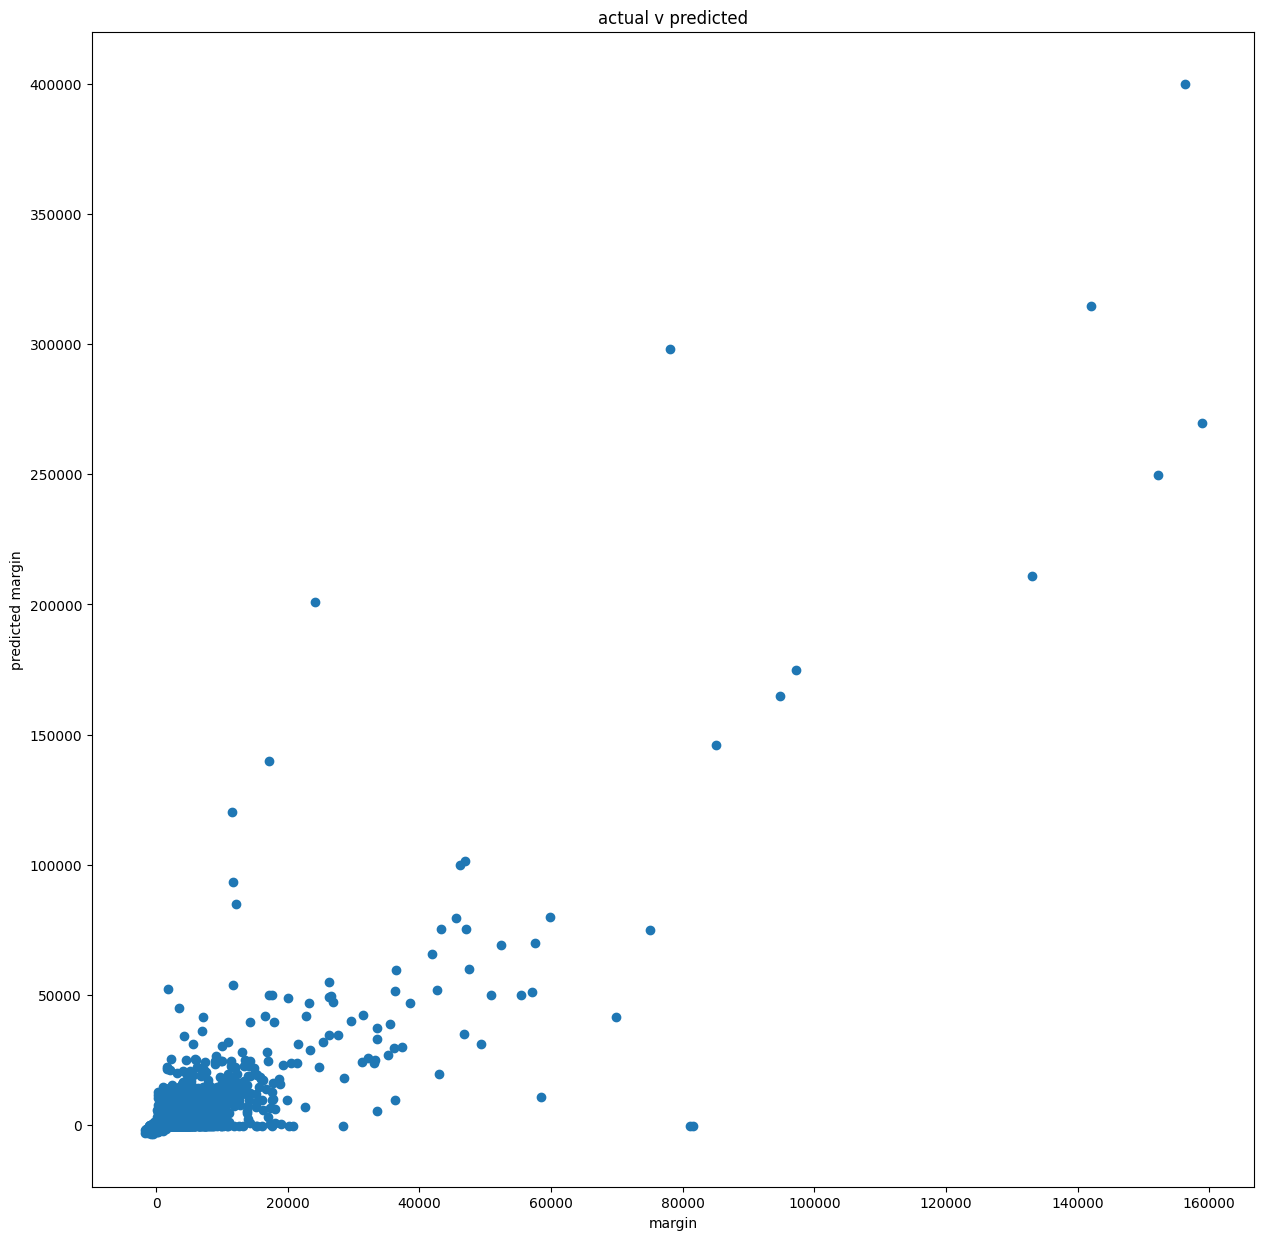

In [3]:
# Converting P_log_margin_Y_pos_1 back to P_margin_Y_pos_1
combined_df['P_margin_Y_pos_1']=10**combined_df['P_log_margin_Y_pos_1']-25000



# Plotting predicted untransformed values vs actual untransformed values:

plt.figure(figsize=(15,15))
plt.scatter(combined_df['P_margin_Y_pos_1'], combined_df['margin_Y_pos_1'])
plt.xlabel("margin")
plt.ylabel("predicted margin")
plt.title("actual v predicted")
# plt.xticks([])
# plt.yticks([])
print(" ") 
plt.show()

In [4]:
# CFV Calculation
annual_discount_rate = 0.10
combined_df['CFV_year_plus_3'] = (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**1))/((1+annual_discount_rate)**1) \
    + (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**2))/((1+annual_discount_rate)**2) \
    + (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**3))/((1+annual_discount_rate)**3)

combined_df['CFV_year_plus_2'] = (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**1))/((1+annual_discount_rate)**1) \
    + (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**2))/((1+annual_discount_rate)**2)

combined_df['CFV_year_plus_1'] = (combined_df['P_margin_Y_pos_1']*((1-combined_df['P_churn_year_plus1_ind'])**1))/((1+annual_discount_rate)**1)


In [5]:
combined_df[['P_margin_Y_pos_1', 'CFV_year_plus_3']].describe()

,P_margin_Y_pos_1,CFV_year_plus_3
count,239356.000000,239356.000000
mean,395.009906,809.722000
std,1228.427093,2506.054299
min,-1743.300907,-4154.157458
25%,100.157244,74.592982
50%,201.146304,414.970988
75%,400.750327,837.110833
max,158829.356991,321330.811081


In [6]:
combined_df[combined_df['CFV_year_plus_3']<0].count()['CFV_year_plus_3']

4251

In [7]:
combined_df[combined_df['CFV_year_plus_3']<0][['acct_ID','P_churn_year_plus1_ind','P_margin_Y_pos_1']].head()

,acct_ID,P_churn_year_plus1_ind,P_margin_Y_pos_1
74,I137058418,0.648906,-201.580462
105,I136955552,0.420548,-19.577264
141,I136939717,0.145560,-440.688692
160,I137179043,0.508133,-25.141668
326,I136900269,0.001404,-40.267598


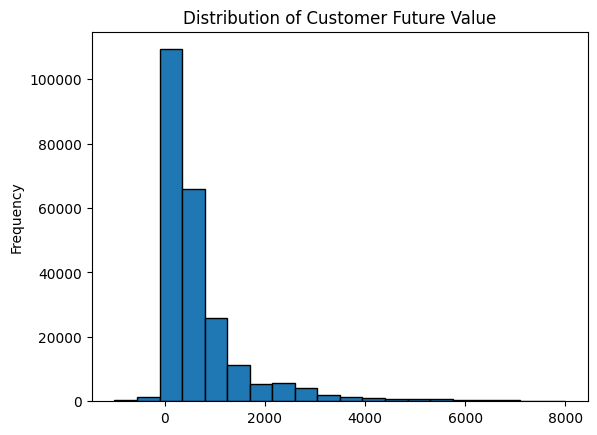

,emailable_x,solicit_ph_ind_x,solicit_email_ind_x,fixd_incm_flg_x,scheduled_purchase_flg_x,months_since_last_trans_x,months_since_first_trans_x,purch_cnt_life,purch_amt_life,purch_cnt_cc_36mo,...,demog_homevalue_$500000 - $599999,demog_homevalue_$600000 - $699999,demog_homevalue_$700000 - $799999,demog_homevalue_$800000 - $999999,demog_homevalue_Less than $50000,P_log_margin_Y_pos_1,P_margin_Y_pos_1,CFV_year_plus_3,CFV_year_plus_2,CFV_year_plus_1
count,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,2.393560e+05,239356.000000,...,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000
mean,0.514919,0.892403,0.964087,0.092502,0.259989,2.915243,65.631365,56.105834,3.346254e+03,4.653048,...,0.012517,0.006676,0.003196,0.003288,0.215474,4.404484,395.009906,809.722000,579.642493,313.737819
std,0.499778,0.309871,0.186074,0.289734,0.438629,3.110888,58.178441,75.756612,2.174355e+04,9.305270,...,0.111177,0.081435,0.056444,0.057247,0.411152,0.013514,1228.427093,2506.054299,1810.151331,988.651176
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.366548,-1743.300907,-4154.157458,-2928.511588,-1550.136370
25%,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,14.000000,8.000000,2.200000e+02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.399676,100.157244,74.592982,64.615776,44.535298
50%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,46.000000,26.000000,8.100000e+02,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.401420,201.146304,414.970988,302.556823,165.304481
75%,1.000000,1.000000,1.000000,0.000000,1.000000,4.000000,110.000000,73.000000,2.705000e+03,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,4.404847,400.750327,837.110833,599.917647,324.707180
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,290.000000,2639.000000,5.498703e+06,189.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,5.264415,158829.356991,321330.811081,235174.861589,129533.552431


In [8]:
# Plotting the distribution of the 3 year CFV
plothist = combined_df['CFV_year_plus_3'].plot.hist(title="Distribution of Customer Future Value",bins=20, range=(-1000,8000),edgecolor='black')
plt.show()
combined_df.describe()

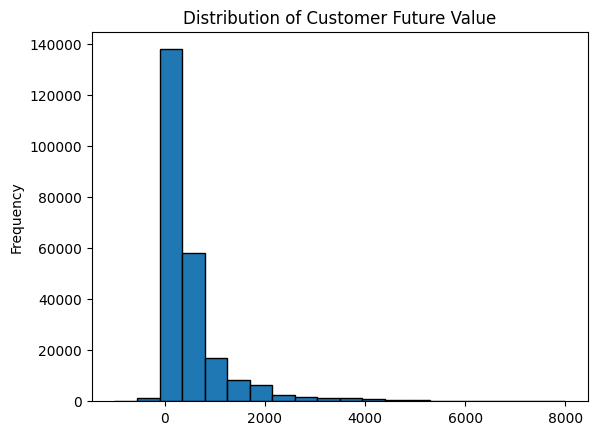

In [9]:
# Plotting the distribution of the 2 year CFV
plothist = combined_df['CFV_year_plus_2'].plot.hist(title="Distribution of Customer Future Value",bins=20, range=(-1000,8000),edgecolor='black')
plt.show()

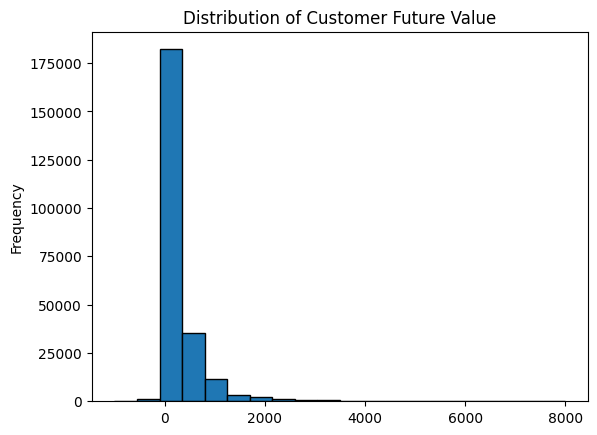

In [10]:
# Plotting the distribution of the 1 year CFV
plothist = combined_df['CFV_year_plus_1'].plot.hist(title="Distribution of Customer Future Value",bins=20, range=(-1000,8000),edgecolor='black')
plt.show()

# Quadrant Calculation

In [11]:
print("mean churn: ",  np.mean(combined_df['P_churn_year_plus1_ind']))
print("median margin: %d" % (np.median(combined_df['P_margin_Y_pos_1'])))

# initializing to values which should not occur after logic below.
combined_df['retention_grp'] = '0X'
combined_df['margin_grp'] = '0X'
combined_df['quadrant_retention_margin'] = 'error_error'

combined_df.loc[combined_df['P_churn_year_plus1_ind']<np.mean(combined_df['P_churn_year_plus1_ind']),'retention_grp']="2H"
combined_df.loc[combined_df['P_churn_year_plus1_ind']>=np.mean(combined_df['P_churn_year_plus1_ind']),'retention_grp']="1L"

combined_df.loc[(combined_df['P_margin_Y_pos_1']<np.median(combined_df['P_margin_Y_pos_1'])),'margin_grp']="1L"
combined_df.loc[(combined_df['P_margin_Y_pos_1']>=np.median(combined_df['P_margin_Y_pos_1'])),'margin_grp']="2H"

combined_df.loc[(combined_df['retention_grp'] == '1L') & (combined_df['margin_grp'] == '1L'),'quadrant_retention_margin'] = "1L_1L"
combined_df.loc[(combined_df['retention_grp'] == '1L') & (combined_df['margin_grp'] == '2H'),'quadrant_retention_margin'] = "1L_2H"
combined_df.loc[(combined_df['retention_grp'] == '2H') & (combined_df['margin_grp'] == '1L'),'quadrant_retention_margin'] = "2H_1L"
combined_df.loc[(combined_df['retention_grp'] == '2H') & (combined_df['margin_grp'] == '2H'),'quadrant_retention_margin'] = "2H_2H"

mean churn:  0.2638719789020313
median margin: 201


# Quadrants Explanation
1. Quadrant 1L_1L (Low Retention, Low Margin)
2. Quadrant 1L_2H (Low Retention, High Margin)
3. Quadrant 2H_1L (High Retention, Low Margin)
4. Quadrant 2H_2H (High Retention, High Margin)


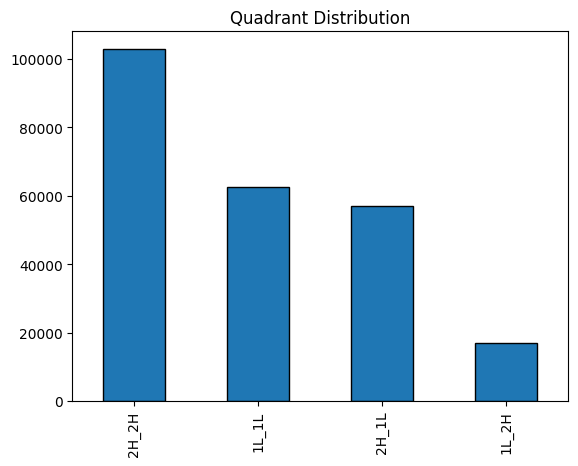

In [12]:
# plot the quadrants with labels of count and percentage on each bar
combined_df['quadrant_retention_margin'].value_counts().plot(kind='bar', title="Quadrant Distribution", edgecolor='black')
plt.show()




In [13]:
# GEt the count for each quadrant
quadrant_counts = combined_df['quadrant_retention_margin'].value_counts()

quadrant_counts

2H_2H    102834
1L_1L     62670
2H_1L     57008
1L_2H     16844
Name: quadrant_retention_margin, dtype: int64

In [16]:
combined_df.to_csv('CLV_scores.csv',index=False)

# Bucketing Churn to 4 buckets

In [17]:
combined_df = pd.read_csv('CLV_scores.csv')

C:\Users\roedj\AppData\Local\Temp\ipykernel_82680\3390971235.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('CLV_scores.csv')


In [35]:
# split the churn values into 0.25, 0.5, 0.75, 1.0 and see how many are in each bucket
# like if churn < 0.25, how many are there, if churn < 0.5, how many are there, etc.

def churn_bucket(churn_value):
    if churn_value < 0.25:
        return 'less than 0.25'
    elif churn_value < 0.5:
        return '0.25 < churn < 0.5'
    elif churn_value < 0.75:
        return '0.5 < churn < 0.75'
    else:
        return '> 0.75'

combined_df['P_churn_bucket'] = combined_df['P_churn_year_plus1_ind'].apply(churn_bucket)

# Value counts for the churn buckets with percentages
churn_bucket_counts = combined_df['P_churn_bucket'].value_counts()
churn_bucket_counts = churn_bucket_counts/churn_bucket_counts.sum()
churn_bucket_counts


less than 0.25        0.660259
> 0.75                0.156541
0.5 < churn < 0.75    0.099166
0.25 < churn < 0.5    0.084034
Name: P_churn_bucket, dtype: float64

# Bucketing Margin to 4 buckets

In [20]:
combined_df['P_margin_Y_pos_1'].describe()

count    239356.000000
mean        395.009906
std        1228.427093
min       -1743.300907
25%         100.157244
50%         201.146304
75%         400.750327
max      158829.356991
Name: P_margin_Y_pos_1, dtype: float64

In [38]:
# split the margin values into <0, 0<500, 500<1000, 1000<1500, 1500<2000, >2000 and see how many are in each bucket 
# like if margin < 0, how many are there, if margin < 500, how many are there, etc.
def margin_bucket(margin_value):
    if margin_value < 0:
        return 'less than 0'
    elif margin_value < 500:
        return '0 < margin < 500'
    elif margin_value < 1000:
        return '500 < margin < 1000'
    elif margin_value < 1500:
        return '1000 < margin < 1500'
    else:
        return 'greater than 1500'

combined_df['margin_bucket'] = combined_df['P_margin_Y_pos_1'].apply(margin_bucket)

# Value counts for the churn buckets with percentages
margin_bucket_counts = combined_df['margin_bucket'].value_counts()
margin_bucket_counts = margin_bucket_counts/margin_bucket_counts.sum()
margin_bucket_counts


0 < margin < 500        0.801672
500 < margin < 1000     0.103716
1000 < margin < 1500    0.039610
greater than 1500       0.037242
less than 0             0.017760
Name: margin_bucket, dtype: float64

# Customer Segmentation

In [26]:
combined_df = pd.read_csv('CLV_scores.csv')


C:\Users\roedj\AppData\Local\Temp\ipykernel_82680\3559417687.py:1: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_df = pd.read_csv('CLV_scores.csv')


In [27]:
# log_margin_3yr_avg and log_purch_amt_36mo
# months_since_last_trans and purch_avg_interval
# P_churn_year_plus1_ind and P_margin_Y_pos_1
# get the above columns

seg_df = combined_df[['log_margin_3yr_avg','log_purch_amt_36mo','months_since_last_trans_x','purch_avg_interval_y','P_churn_year_plus1_ind','P_margin_Y_pos_1']]
seg_df.describe()



,log_margin_3yr_avg,log_purch_amt_36mo,months_since_last_trans_x,purch_avg_interval_y,P_churn_year_plus1_ind,P_margin_Y_pos_1
count,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000,239356.000000
mean,4.400946,2.604440,2.915243,4.918283,0.263872,395.009906
std,0.014507,0.647132,3.110888,10.070988,0.325842,1228.427093
min,4.173389,0.000000,1.000000,0.000000,0.001012,-1743.300907
25%,4.398445,2.206826,1.000000,1.000000,0.009793,100.157244
50%,4.400176,2.712650,1.000000,1.220000,0.091570,201.146304
75%,4.402898,3.025715,4.000000,2.590000,0.518370,400.750327
max,5.611186,6.086360,12.000000,168.000000,0.993986,158829.356991


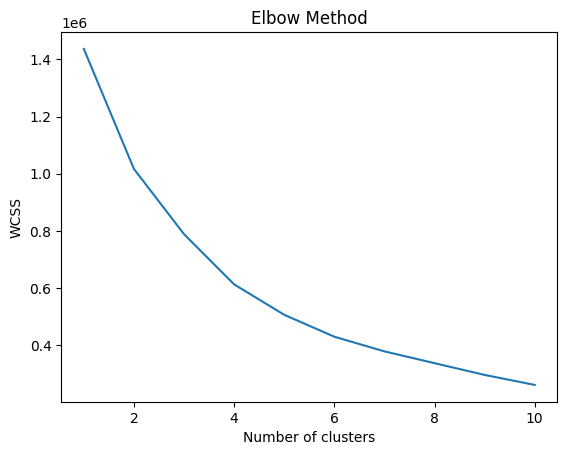

In [28]:
# Perform the KMeans clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
seg_df_scaled = scaler.fit_transform(seg_df)

# elbow method to find the optimal number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(seg_df_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


In [29]:
kmeans = KMeans(n_clusters=6, random_state=0).fit(seg_df_scaled)


# Add the cluster to the dataframe
seg_df['cluster'] = kmeans.labels_

seg_df['cluster'].value_counts()



c:\Users\roedj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\roedj\AppData\Local\Temp\ipykernel_82680\230773439.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_df['cluster'] = kmeans.labels_


4    108799
1     54392
0     51494
2     20223
5      4395
3        53
Name: cluster, dtype: int64

In [30]:
# profile the clusters based on demographic data
cluster_profile = seg_df.groupby('cluster').mean()

cluster_profile

,log_margin_3yr_avg,log_purch_amt_36mo,months_since_last_trans_x,purch_avg_interval_y,P_churn_year_plus1_ind,P_margin_Y_pos_1
cluster,,,,,,
0,4.409912,3.322361,1.310580,1.402494,0.050589,926.979750
1,4.399792,2.362782,7.355163,2.713438,0.752613,131.048112
2,4.398072,1.448242,3.418434,36.241104,0.441037,156.639296
3,4.908056,5.269133,2.603774,2.816604,0.119507,56475.205935
4,4.400105,2.551207,1.390555,1.988724,0.093442,207.414635
5,4.338110,3.789375,2.200683,1.817276,0.119754,2493.451603


In [31]:
# merge cluster 3 and 4
seg_df['cluster'] = seg_df['cluster'].replace(5,2)

C:\Users\roedj\AppData\Local\Temp\ipykernel_82680\719912213.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_df['cluster'] = seg_df['cluster'].replace(5,2)


In [32]:
cluster_profile = seg_df.groupby('cluster').mean()
cluster_profile

,log_margin_3yr_avg,log_purch_amt_36mo,months_since_last_trans_x,purch_avg_interval_y,P_churn_year_plus1_ind,P_margin_Y_pos_1
cluster,,,,,,
0,4.409912,3.322361,1.310580,1.402494,0.050589,926.979750
1,4.399792,2.362782,7.355163,2.713438,0.752613,131.048112
2,4.387367,1.866199,3.201032,30.095490,0.383679,573.825505
3,4.908056,5.269133,2.603774,2.816604,0.119507,56475.205935
4,4.400105,2.551207,1.390555,1.988724,0.093442,207.414635


In [33]:
# merge cluster 3 and 4
seg_df['cluster'] = seg_df['cluster'].replace(3,0)

cluster_profile = seg_df.groupby('cluster').mean()
cluster_profile

C:\Users\roedj\AppData\Local\Temp\ipykernel_82680\3811526463.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  seg_df['cluster'] = seg_df['cluster'].replace(3,0)


,log_margin_3yr_avg,log_purch_amt_36mo,months_since_last_trans_x,purch_avg_interval_y,P_churn_year_plus1_ind,P_margin_Y_pos_1
cluster,,,,,,
0,4.410424,3.324362,1.311910,1.403948,0.050660,984.093762
1,4.399792,2.362782,7.355163,2.713438,0.752613,131.048112
2,4.387367,1.866199,3.201032,30.095490,0.383679,573.825505
4,4.400105,2.551207,1.390555,1.988724,0.093442,207.414635


In [34]:
# merge clsuter number back to the original dataframe
combined_df['cluster'] = seg_df['cluster']
# to csv
combined_df.to_csv('segmentation.csv',index=False)